In [1]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from config import postgresPass as pw

In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')

In [3]:
import numpy as np
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import func, inspect

In [5]:
protocol = 'postgresql'
username = 'postgres'
password = pw
host = 'localhost'
port = 5432
database_name = 'bike_shop_lc'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['customers',
 'combined_sales',
 'calendar',
 'products',
 'categories',
 'returns',
 'territories']

In [8]:
inspector = inspect(engine)
inspector.get_table_names()

['customers',
 'combined_sales',
 'calendar',
 'products',
 'categories',
 'returns',
 'territories']

In [9]:
# Get a list of column names and types for customers
customers_columns = inspector.get_columns('customers')
for c in customers_columns:
    print(c['name'], c["type"])

customerkey INTEGER
prefix VARCHAR
firstname VARCHAR
lastname VARCHAR
birthdate VARCHAR
maritalstatus VARCHAR
gender VARCHAR
emailaddress VARCHAR
annualincome INTEGER
totalchildren INTEGER
educationlevel VARCHAR
occupation VARCHAR
homeowner VARCHAR


In [10]:
# Save references to each table
customers = Base.classes.customers
sales = Base.classes.combined_sales
calendar = Base.classes.calendar
products = Base.classes.products
categories = Base.classes.categories
returns = Base.classes.returns
territories = Base.classes.territories

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.min(sales.orderdate)).first()
most_recent_date

('2015-01-01',)

In [13]:
# Design a query to calculate the total number customers in the dataset
session.query(func.count(customers.customerkey)).all()

[(18148,)]

In [14]:
# Design a query to calculate the total number customers in each Education Level
result1 = session.query(customers.educationlevel, func.count(customers.educationlevel)).\
    group_by(customers.educationlevel).order_by(func.count(customers.educationlevel).desc()).all()

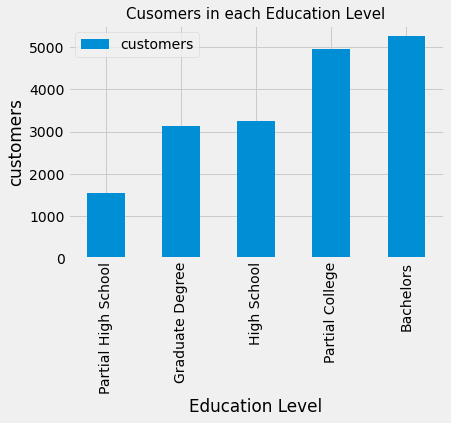

In [15]:
df1 = pd.DataFrame(result1)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df1 = pd.DataFrame(result1,columns=['Education Level', 'customers'])

# Sort the dataframe by date
df1 = df1.sort_values('customers')

# Use Pandas Plotting with Matplotlib to plot the data

df1.plot.bar(x='Education Level', y='customers', rot=90)
plt.xlabel("Education Level")
plt.ylabel("customers")

# Add title
plt.title("Cusomers in each Education Level", fontsize=15)

# Save to folder
plt.savefig("Resources/Education Level.png")

In [16]:
# Design a query to calculate the total number customers in each Annual Income bracket
result2 = session.query(customers.annualincome, func.count(customers.annualincome)).\
    group_by(customers.annualincome).order_by(func.count(customers.annualincome).desc()).all()

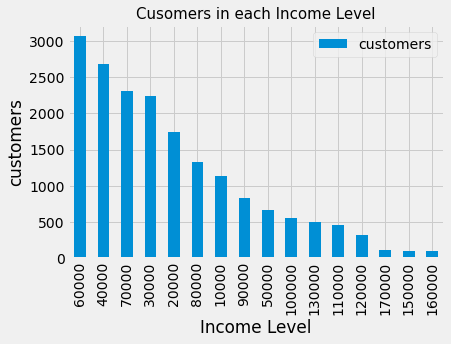

In [17]:
df2 = pd.DataFrame(result2)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df2 = pd.DataFrame(result2,columns=['Income Level', 'customers'])

# Use Pandas Plotting with Matplotlib to plot the data

df2.plot.bar(x='Income Level', y='customers', rot=90)
plt.xlabel("Income Level")
plt.ylabel("customers")

# Add title
plt.title("Cusomers in each Income Level", fontsize=15)

# Save to folder
plt.savefig("Resources/Income Level.png")

In [18]:
# Get a list of column names and types for products
product_columns = inspector.get_columns('products')
for p in product_columns:
    print(p['name'], p["type"])

productkey INTEGER
productsubcategorykey INTEGER
productsku VARCHAR
productname VARCHAR
modelname VARCHAR
productdescription VARCHAR
productcolor VARCHAR
productsize VARCHAR
productstyle VARCHAR
productcost INTEGER
productprice INTEGER


In [19]:
# Design a query to calculate the total number of products in each product sub category
result3 = session.query(products.productsubcategorykey, func.count(products.productsubcategorykey)).\
    group_by(products.productsubcategorykey).order_by(products.productsubcategorykey).all()

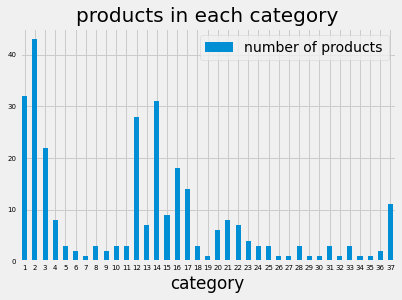

In [20]:
df3 = pd.DataFrame(result3)

# Save the query results as a Pandas DataFrame and set the index to the Education Level column
df3 = pd.DataFrame(result3,columns=['category', 'number of products'])

# Use Pandas Plotting with Matplotlib to plot the data

df3.plot.bar(x='category', y='number of products',rot=0,fontsize=7 )
plt.xlabel("category")
# plt.ylabel("number of products")

# Add title
plt.title("products in each category", fontsize=20)

# Save to folder
plt.savefig("Resources/Categories.png")

In [21]:
all_sales_df = pd.read_sql_query(
    """
    SELECT
    "productkey",
    "customerkey",
    "salesterritorykey",
    "orderquantity"
    FROM combined_sales
    """,
    con=engine)

In [22]:
all_sales_df

,productkey,customerkey,salesterritorykey,orderquantity
0,332,14657,1,1
1,312,29255,4,1
2,350,11455,9,1
3,338,26782,6,1
4,312,14947,10,1
...,...,...,...,...
56041,477,28517,10,2
56042,479,28517,10,1
56043,606,28517,10,1
56044,480,21676,7,2


In [23]:
territories_df = pd.read_sql_query(
    """
    SELECT
    "salesterritorykey",
    "region",
    "continent"
    FROM territories
    """,
    con=engine)

In [24]:
territories_df

,salesterritorykey,region,continent
0,1,Northwest,North America
1,2,Northeast,North America
2,3,Central,North America
3,4,Southwest,North America
4,5,Southeast,North America
5,6,Canada,North America
6,7,France,Europe
7,8,Germany,Europe
8,9,Australia,Pacific
9,10,United Kingdom,Europe


In [25]:
all_sales_df1 = pd.merge(all_sales_df,territories_df, how="left",on='salesterritorykey')

In [26]:
all_sales_df1

,productkey,customerkey,salesterritorykey,orderquantity,region,continent
0,332,14657,1,1,Northwest,North America
1,312,29255,4,1,Southwest,North America
2,350,11455,9,1,Australia,Pacific
3,338,26782,6,1,Canada,North America
4,312,14947,10,1,United Kingdom,Europe
...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe
56042,479,28517,10,1,United Kingdom,Europe
56043,606,28517,10,1,United Kingdom,Europe
56044,480,21676,7,2,France,Europe


In [27]:
products_df = pd.read_sql_query(
    """
    SELECT
    "productkey",
    "modelname",
    "productsubcategorykey"
    FROM products
    """,
    con=engine)

In [28]:
products_df

,productkey,modelname,productsubcategorykey
0,214,Sport-100,31
1,215,Sport-100,31
2,218,Mountain Bike Socks,23
3,219,Mountain Bike Socks,23
4,220,Sport-100,31
...,...,...,...
288,602,ML Bottom Bracket,5
289,603,HL Bottom Bracket,5
290,604,Road-750,2
291,605,Road-750,2


In [29]:
all_sales_df2 = pd.merge(all_sales_df1,products_df, how="left",on='productkey')

In [30]:
all_sales_df2

,productkey,customerkey,salesterritorykey,orderquantity,region,continent,modelname,productsubcategorykey
0,332,14657,1,1,Northwest,North America,Road-650,2
1,312,29255,4,1,Southwest,North America,Road-150,2
2,350,11455,9,1,Australia,Pacific,Mountain-100,1
3,338,26782,6,1,Canada,North America,Road-650,2
4,312,14947,10,1,United Kingdom,Europe,Road-150,2
...,...,...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe,Water Bottle,28
56042,479,28517,10,1,United Kingdom,Europe,Road Bottle Cage,28
56043,606,28517,10,1,United Kingdom,Europe,Road-750,2
56044,480,21676,7,2,France,Europe,Patch kit,37


In [31]:
categories_df = pd.read_sql_query(
    """
    SELECT
    "productsubcategorykey",
    "categoryname"
    FROM categories
    """,
    con=engine)

In [32]:
categories_df

,productsubcategorykey,categoryname
0,1,Bikes
1,2,Bikes
2,3,Bikes
3,4,Components
4,5,Components
5,6,Components
6,7,Components
7,8,Components
8,9,Components
9,10,Components


In [33]:
all_sales_df3 = pd.merge(all_sales_df2,categories_df, how="left",on='productsubcategorykey')

In [34]:
all_sales_df3

,productkey,customerkey,salesterritorykey,orderquantity,region,continent,modelname,productsubcategorykey,categoryname
0,332,14657,1,1,Northwest,North America,Road-650,2,Bikes
1,312,29255,4,1,Southwest,North America,Road-150,2,Bikes
2,350,11455,9,1,Australia,Pacific,Mountain-100,1,Bikes
3,338,26782,6,1,Canada,North America,Road-650,2,Bikes
4,312,14947,10,1,United Kingdom,Europe,Road-150,2,Bikes
...,...,...,...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe,Water Bottle,28,Accessories
56042,479,28517,10,1,United Kingdom,Europe,Road Bottle Cage,28,Accessories
56043,606,28517,10,1,United Kingdom,Europe,Road-750,2,Bikes
56044,480,21676,7,2,France,Europe,Patch kit,37,Accessories


In [35]:
customers_df = pd.read_sql_query(
    """
    SELECT
    customerkey,
    gender,
    educationlevel
   FROM customers;
     
    """,
    con=engine)

In [36]:
customers_df

,customerkey,gender,educationlevel
0,11000,M,Bachelors
1,11001,M,Bachelors
2,11002,M,Bachelors
3,11003,F,Bachelors
4,11004,F,Bachelors
...,...,...,...
18143,29479,M,Graduate Degree
18144,29480,F,Graduate Degree
18145,29481,M,Graduate Degree
18146,29482,M,Bachelors


In [37]:
all_sales_df4 = pd.merge(all_sales_df3,customers_df, how="left",on='customerkey')

In [38]:
all_sales_df4

,productkey,customerkey,salesterritorykey,orderquantity,region,continent,modelname,productsubcategorykey,categoryname,gender,educationlevel
0,332,14657,1,1,Northwest,North America,Road-650,2,Bikes,M,Partial College
1,312,29255,4,1,Southwest,North America,Road-150,2,Bikes,M,Partial College
2,350,11455,9,1,Australia,Pacific,Mountain-100,1,Bikes,M,High School
3,338,26782,6,1,Canada,North America,Road-650,2,Bikes,M,High School
4,312,14947,10,1,United Kingdom,Europe,Road-150,2,Bikes,M,High School
...,...,...,...,...,...,...,...,...,...,...,...
56041,477,28517,10,2,United Kingdom,Europe,Water Bottle,28,Accessories,M,Partial College
56042,479,28517,10,1,United Kingdom,Europe,Road Bottle Cage,28,Accessories,M,Partial College
56043,606,28517,10,1,United Kingdom,Europe,Road-750,2,Bikes,M,Partial College
56044,480,21676,7,2,France,Europe,Patch kit,37,Accessories,F,Partial High School


In [39]:
all_sales_df4.pop('continent')

0        North America
1        North America
2              Pacific
3        North America
4               Europe
             ...      
56041           Europe
56042           Europe
56043           Europe
56044           Europe
56045           Europe
Name: continent, Length: 56046, dtype: object

In [40]:
all_sales_df4.pop('salesterritorykey')

0         1
1         4
2         9
3         6
4        10
         ..
56041    10
56042    10
56043    10
56044     7
56045     7
Name: salesterritorykey, Length: 56046, dtype: int64

In [41]:
all_sales_df4.pop('productsubcategorykey')

0         2
1         2
2         1
3         2
4         2
         ..
56041    28
56042    28
56043     2
56044    37
56045    37
Name: productsubcategorykey, Length: 56046, dtype: int64

In [42]:
all_sales_df4

,productkey,customerkey,orderquantity,region,modelname,categoryname,gender,educationlevel
0,332,14657,1,Northwest,Road-650,Bikes,M,Partial College
1,312,29255,1,Southwest,Road-150,Bikes,M,Partial College
2,350,11455,1,Australia,Mountain-100,Bikes,M,High School
3,338,26782,1,Canada,Road-650,Bikes,M,High School
4,312,14947,1,United Kingdom,Road-150,Bikes,M,High School
...,...,...,...,...,...,...,...,...
56041,477,28517,2,United Kingdom,Water Bottle,Accessories,M,Partial College
56042,479,28517,1,United Kingdom,Road Bottle Cage,Accessories,M,Partial College
56043,606,28517,1,United Kingdom,Road-750,Bikes,M,Partial College
56044,480,21676,2,France,Patch kit,Accessories,F,Partial High School


In [43]:
# Get all the data for Bikes. 
just_bikes_df = all_sales_df4.loc[all_sales_df4["categoryname"] == "Bikes"]
just_bikes_df

,productkey,customerkey,orderquantity,region,modelname,categoryname,gender,educationlevel
0,332,14657,1,Northwest,Road-650,Bikes,M,Partial College
1,312,29255,1,Southwest,Road-150,Bikes,M,Partial College
2,350,11455,1,Australia,Mountain-100,Bikes,M,High School
3,338,26782,1,Canada,Road-650,Bikes,M,High School
4,312,14947,1,United Kingdom,Road-150,Bikes,M,High School
...,...,...,...,...,...,...,...,...
56022,354,14984,1,United Kingdom,Mountain-200,Bikes,F,Partial College
56029,375,22202,1,Australia,Road-250,Bikes,M,High School
56031,383,22253,1,Northwest,Road-550-W,Bikes,F,Graduate Degree
56034,358,21266,1,Canada,Mountain-200,Bikes,F,Bachelors


In [44]:
just_bikes_df.pop('productkey')

0        332
1        312
2        350
3        338
4        312
        ... 
56022    354
56029    375
56031    383
56034    358
56043    606
Name: productkey, Length: 13929, dtype: int64

In [45]:
just_bikes_df.pop('customerkey')

0        14657
1        29255
2        11455
3        26782
4        14947
         ...  
56022    14984
56029    22202
56031    22253
56034    21266
56043    28517
Name: customerkey, Length: 13929, dtype: int64

In [46]:
just_bikes_df

,orderquantity,region,modelname,categoryname,gender,educationlevel
0,1,Northwest,Road-650,Bikes,M,Partial College
1,1,Southwest,Road-150,Bikes,M,Partial College
2,1,Australia,Mountain-100,Bikes,M,High School
3,1,Canada,Road-650,Bikes,M,High School
4,1,United Kingdom,Road-150,Bikes,M,High School
...,...,...,...,...,...,...
56022,1,United Kingdom,Mountain-200,Bikes,F,Partial College
56029,1,Australia,Road-250,Bikes,M,High School
56031,1,Northwest,Road-550-W,Bikes,F,Graduate Degree
56034,1,Canada,Mountain-200,Bikes,F,Bachelors


In [47]:
just_bikes_df.to_csv('Resources/just_bikes.csv',index = False)

In [48]:
df = pd.read_csv (r'Resources/just_bikes.csv')
df.to_json (r'Resources/just_bikes.json')

In [49]:
df1 = pd.read_csv (r'Resources/combined_sales.csv')
df1.to_json (r'Resources/combined_sales.json')

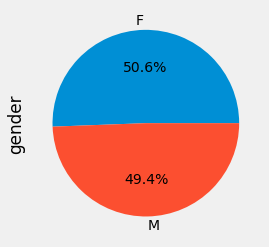

<Figure size 432x288 with 0 Axes>

In [50]:
# Generate a pie plot showing the distribution of female versus male bike sales
counts = just_bikes_df.gender.value_counts()
counts.plot(kind="pie",autopct='%1.1f%%')
plt.show()
# Save to folder
plt.savefig("Resources/bike_sales_gender.png")

In [51]:
# Get model name data
model_data = just_bikes_df["modelname"].value_counts()
model_data

Mountain-200      3481
Road-250          1874
Road-750          1422
Road-550-W        1358
Touring-1000      1233
Road-350-W         911
Road-150           812
Road-650           722
Mountain-400-W     533
Touring-3000       530
Mountain-500       473
Touring-2000       361
Mountain-100       219
Name: modelname, dtype: int64

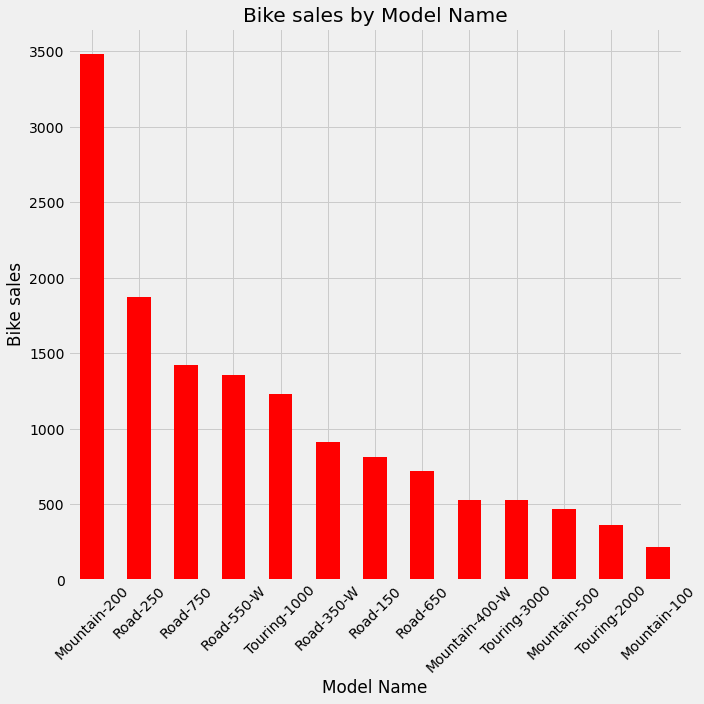

In [52]:
# Create plot
model_data.plot(kind="bar", facecolor="red", rot=45,figsize=(10,10) )

# Set title and axis labels
plt.title("Bike sales by Model Name")
plt.ylabel("Bike sales")
plt.xlabel("Model Name")

# Resize plot to display labels
plt.tight_layout()
plt.savefig("Resources/bike_sales_Model.png")

In [53]:
# Get Education Level data
Education_data = just_bikes_df["educationlevel"].value_counts()
Education_data

Bachelors              4694
Partial College        3812
Graduate Degree        2499
High School            2129
Partial High School     795
Name: educationlevel, dtype: int64

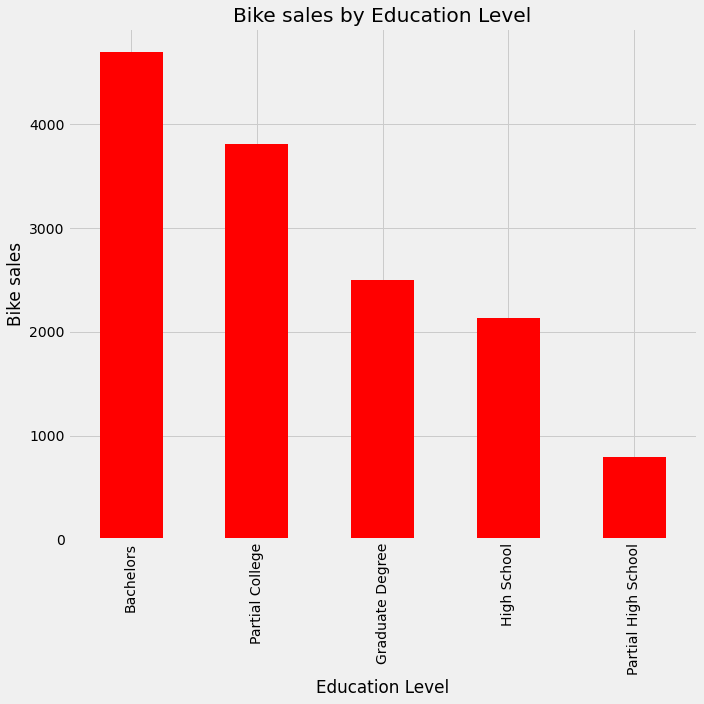

In [54]:
# Create plot
Education_data.plot(kind="bar", facecolor="red", rot=90,figsize=(10,10) )

# Set title and axis labels
plt.title("Bike sales by Education Level")
plt.ylabel("Bike sales")
plt.xlabel("Education Level")

# Resize plot to display labels
plt.tight_layout()
plt.savefig("Resources/bike_sales_Education.png")

In [55]:
customers_join = pd.read_sql_query(
    """
    SELECT
    c.customerkey,
    c.gender,
    c.educationlevel,
    cs.customerkey,
    cs.salesterritorykey
    FROM customers AS c
    INNER JOIN combined_sales AS cs
    ON c.customerkey = cs.customerkey;
     
    """,
    con=engine)

In [56]:
customers_join

,customerkey,gender,educationlevel,customerkey,salesterritorykey
0,14657,M,Partial College,14657,1
1,29255,M,Partial College,29255,4
2,11455,M,High School,11455,9
3,26782,M,High School,26782,6
4,14947,M,High School,14947,10
...,...,...,...,...,...
56041,28517,M,Partial College,28517,10
56042,28517,M,Partial College,28517,10
56043,28517,M,Partial College,28517,10
56044,21676,F,Partial High School,21676,7


In [57]:
products_join = pd.read_sql_query(
    """
    SELECT
    p.productkey,
    p.productsubcategorykey,
    p.modelname,
    cs.productkey,
    cs.orderquantity
    FROM products AS p
    INNER JOIN combined_sales AS cs
    ON p.productkey = cs.productkey;
     
    """,
    con=engine)

In [58]:
products_join

,productkey,productsubcategorykey,modelname,productkey,orderquantity
0,332,2,Road-650,332,1
1,312,2,Road-150,312,1
2,350,1,Mountain-100,350,1
3,338,2,Road-650,338,1
4,312,2,Road-150,312,1
...,...,...,...,...,...
56041,477,28,Water Bottle,477,2
56042,479,28,Road Bottle Cage,479,1
56043,606,2,Road-750,606,1
56044,480,37,Patch kit,480,2


In [67]:
# Get all the data for Bikes. 
just_bikes_df01 = products_join.loc[products_join["productsubcategorykey"] <= 3]
just_bikes_df01

,productkey,productsubcategorykey,modelname,productkey,orderquantity
0,332,2,Road-650,332,1
1,312,2,Road-150,312,1
2,350,1,Mountain-100,350,1
3,338,2,Road-650,338,1
4,312,2,Road-150,312,1
...,...,...,...,...,...
56022,354,1,Mountain-200,354,1
56029,375,2,Road-250,375,1
56031,383,2,Road-550-W,383,1
56034,358,1,Mountain-200,358,1


In [68]:
just_bikes_df01.pop('productkey')

,productkey,productkey
0,332,332
1,312,312
2,350,350
3,338,338
4,312,312
...,...,...
56022,354,354
56029,375,375
56031,383,383
56034,358,358


In [69]:
just_bikes_df01

,productsubcategorykey,modelname,orderquantity
0,2,Road-650,1
1,2,Road-150,1
2,1,Mountain-100,1
3,2,Road-650,1
4,2,Road-150,1
...,...,...,...
56022,1,Mountain-200,1
56029,2,Road-250,1
56031,2,Road-550-W,1
56034,1,Mountain-200,1


In [75]:
data = model_data.to_json(orient='index')
print(data)

{"Mountain-200":3481,"Road-250":1874,"Road-750":1422,"Road-550-W":1358,"Touring-1000":1233,"Road-350-W":911,"Road-150":812,"Road-650":722,"Mountain-400-W":533,"Touring-3000":530,"Mountain-500":473,"Touring-2000":361,"Mountain-100":219}


In [73]:
import pprint

In [76]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(data)

'{"Mountain-200":3481,"Road-250":1874,"Road-750":1422,"Road-550-W":1358,"Touring-1000":1233,"Road-350-W":911,"Road-150":812,"Road-650":722,"Mountain-400-W":533,"Touring-3000":530,"Mountain-500":473,"Touring-2000":361,"Mountain-100":219}'


In [59]:
# Get all the data for Bikes. 
just_bikes_df1 = products_join.loc[products_join["productsubcategorykey"] <= 3]
just_bikes_df1

,productkey,productsubcategorykey,modelname,productkey,orderquantity
0,332,2,Road-650,332,1
1,312,2,Road-150,312,1
2,350,1,Mountain-100,350,1
3,338,2,Road-650,338,1
4,312,2,Road-150,312,1
...,...,...,...,...,...
56022,354,1,Mountain-200,354,1
56029,375,2,Road-250,375,1
56031,383,2,Road-550-W,383,1
56034,358,1,Mountain-200,358,1


In [60]:
just_bikes_df1.pop('productkey')

,productkey,productkey
0,332,332
1,312,312
2,350,350
3,338,338
4,312,312
...,...,...
56022,354,354
56029,375,375
56031,383,383
56034,358,358


In [61]:
just_bikes_df1.pop('productsubcategorykey')

0        2
1        2
2        1
3        2
4        2
        ..
56022    1
56029    2
56031    2
56034    1
56043    2
Name: productsubcategorykey, Length: 13929, dtype: int64

In [62]:
just_bikes_df1

,modelname,orderquantity
0,Road-650,1
1,Road-150,1
2,Mountain-100,1
3,Road-650,1
4,Road-150,1
...,...,...
56022,Mountain-200,1
56029,Road-250,1
56031,Road-550-W,1
56034,Mountain-200,1


In [63]:
just_bikes_df2 = just_bikes_df1.groupby(by="modelname", dropna = False).sum()
just_bikes_df2

,orderquantity
modelname,
Mountain-100,219
Mountain-200,3481
Mountain-400-W,533
Mountain-500,473
Road-150,812
Road-250,1874
Road-350-W,911
Road-550-W,1358
Road-650,722


In [66]:
data = just_bikes_df2.to_json(orient='index')
print(data)

{"Mountain-100":{"orderquantity":219},"Mountain-200":{"orderquantity":3481},"Mountain-400-W":{"orderquantity":533},"Mountain-500":{"orderquantity":473},"Road-150":{"orderquantity":812},"Road-250":{"orderquantity":1874},"Road-350-W":{"orderquantity":911},"Road-550-W":{"orderquantity":1358},"Road-650":{"orderquantity":722},"Road-750":{"orderquantity":1422},"Touring-1000":{"orderquantity":1233},"Touring-2000":{"orderquantity":361},"Touring-3000":{"orderquantity":530}}


In [64]:
# Close Session
session.close()